### The Twist

Must expand search window from a single row to (0, 4_000_000) x (0, 4_000_000) matrix.....need to consider efficiencies here. 

What I can do now is as follows:
- Limit to the border of interest
- Find intersection of 


TODO:

- I think it is as simple as storing boundary info & swapping out segments of boundary, just can't formulate a clean appraoch/



Approach: 
- We can build our border
- We can build a border that is + 1, this would represent potential zones but much smaller
- We can find the border + 1 point that is not on a border

In [1]:
import numpy as np

# acceptable range
r_min, r_max = (0,4_000_000)
c_min, c_max = (0,4_000_000)

# adding boundaries
top_row = np.asarray([(r_min, c) for c in range(c_min, c_max+1)])
bot_row = np.asarray([(r_max, c) for c in range(c_min, c_max+1)])
left_col = np.asarray([(r, c_min) for r in range(r_min, r_max+1)])
right_col = np.asarray([(r, c_max) for r in range(r_min, r_max+1)])
boundary = np.concatenate((top_row, bot_row, left_col, right_col))
boundary.shape

(16000004, 2)

In [2]:

    
def manhattan_distance(s, b):
    return abs(s[0] - b[0]) + abs(s[1] - b[1])

def find_four_points(s, md):
    """Input sensor and build all directions based on manhattan distance"""
    
    # col math
    sc_neg = (s[0], s[1] - md)
    sc_pos = (s[0], s[1] + md)
    
    # row math
    sr_neg = (s[0] - md, s[1])
    sr_pos = (s[0] + md, s[1])
    
    return (sc_neg, sc_pos, sr_neg, sr_pos)

    
def flattenArray(l):
    return np.asarray([item for sublist in l for item in sublist])

def buildSensortDict(data):
    """Parse input data into a dict for sensor and beacons"""
    sensor_dict = {}
    for l in data:

        # sensor data
        sx = int(l.split('x=')[1].split(',')[0])
        sy = int(l.split('y=')[1].split(':')[0])

        # beacon data
        beacon = l.split('beacon')[1]
        bx = int(beacon.split('x=')[1].split(',')[0])
        by = int(beacon.split('y=')[1].strip())

        # store as row, col
        sensor_dict[(sy,sx)] = (by,bx)
        
    return sensor_dict

In [3]:
def build_boundary(sc_neg, sc_pos, sr_neg, sr_pos): 
                   #r_min, r_max, c_min_c_max):
    
    """ Build boundary, but only if it falls in bounds"""
    
    
    boundary_set = set((sc_neg, sc_pos, sr_neg, sr_pos))
    
    # start at sc_neg and go row - 1 (up), col + 1 (right) until we hit sr_neg
    row_change, col_change = (-1, 1)
    cur_point = (sc_neg[0] + row_change, sc_neg[1] + col_change)
    while cur_point != sr_neg:
        boundary_set.add(cur_point)
        cur_point = (cur_point[0] + row_change, cur_point[1] + col_change)

    # start at sr_neg and go row + 1 (down), col + 1 (right) until we hit sc_pos
    row_change, col_change = (1, 1)
    cur_point = (sr_neg[0] + row_change, sr_neg[1] + col_change)
    while cur_point != sc_pos:
        boundary_set.add(cur_point)
        cur_point = (cur_point[0] + row_change, cur_point[1] + col_change)

    # start at sc_pos and go row + 1 (down), col - 1 (left) until we hit sr_pos
    row_change, col_change = (1, -1)
    cur_point = (sc_pos[0] + row_change, sc_pos[1] + col_change)
    while cur_point != sr_pos:
        boundary_set.add(cur_point)
        cur_point = (cur_point[0] + row_change, cur_point[1] + col_change)

    # start at sr_pos and go row - 1 (up), col - 1 (left) until we hit sc_neg
    row_change, col_change = (-1, -1)
    cur_point = (sr_pos[0] + row_change, sr_pos[1] + col_change)
    while cur_point != sc_neg:
        boundary_set.add(cur_point)
        cur_point = (cur_point[0] + row_change, cur_point[1] + col_change)
        
    return boundary_set

In [4]:
with open("data/day15_sample.txt", "r", encoding="UTF-8") as f:
    lines = f.read().split("\n")


sensor_dict = buildSensortDict(lines)

# calculate boundaries and offset, which is used mainly
# for indexing / visualization
long_list = []
for k,v in sensor_dict.items():
    long_list.append(k)
    long_list.append(v)
long_list = np.asarray(long_list)

min_r = np.min(long_list[:,0])
max_r = np.max(long_list[:,0])
min_c = np.min(long_list[:,1])
max_c = np.max(long_list[:,1])

print(min_r, max_r)
print(min_c, max_c)
offset = -1 * min_c

# full sample:
full_cov = []
for k,v in sensor_dict.items():
    print(f"finding coverage for {k,v}")
    md = manhattan_distance(k, v)
    a,b,c,d = find_four_points(k, md)
    boundary_set = build_boundary(a,b,c,d)
    
    # build possible set:
    a = (a[0], a[1] - 1) # outward left
    b = (b[0], b[1] + 1) # outward right
    c = (c[0] - 1, c[1]) # expand upward
    d = (d[0] + 1, d[1]) # expand downward
    possible_set = build_boundary(a,b,c,d)
    
    break
    #full_cov.append(coverage)

0 22
-2 25
finding coverage for ((18, 2), (15, -2))


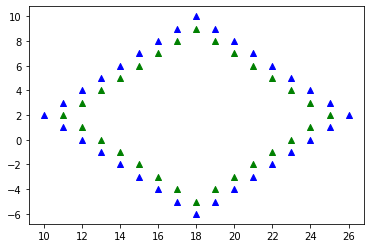

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter([x[0] for x in boundary_set], [x[1] for x in boundary_set], marker='^', c='green')
plt.scatter([x[0] for x in possible_set], [x[1] for x in possible_set], marker='^', c='blue')

### Moving Into Solution: Sample

- Find boundary and eligible zone. 
- Find the single point from eligible zone not in boundary (must fall in bounds shared)

In [6]:
with open("data/day15_sample.txt", "r", encoding="UTF-8") as f:
    lines = f.read().split("\n")

sensor_dict = buildSensortDict(lines)

# calculate boundaries and offset, which is used mainly
# for indexing / visualization
long_list = []
for k,v in sensor_dict.items():
    long_list.append(k)
    long_list.append(v)
long_list = np.asarray(long_list)

min_r = np.min(long_list[:,0])
max_r = np.max(long_list[:,0])
min_c = np.min(long_list[:,1])
max_c = np.max(long_list[:,1])

print(min_r, max_r)
print(min_c, max_c)
offset = -1 * min_c

# full sample:
boundary_zone = []
eligible_zone = []

# store distance for each point
distance_storage = {}
for k,v in sensor_dict.items():
    print(f"finding coverage for {k,v}")
    md = manhattan_distance(k, v)
    distance_storage[k] = md
    a,b,c,d = find_four_points(k, md)
    boundary_zone.append(build_boundary(a,b,c,d))
    
    # build possible set:
    a = (a[0], a[1] - 1) # outward left
    b = (b[0], b[1] + 1) # outward right
    c = (c[0] - 1, c[1]) # expand upward
    d = (d[0] + 1, d[1]) # expand downward
    eligible_zone.append(build_boundary(a,b,c,d))

# clean up
max_r = 20
max_c = 20

elig_blocks = flattenArray(eligible_zone)
eligible_set = [(x[0], x[1]) for x in elig_blocks if x[0] >= 0 and x[0] <= max_r and x[1] >= 0 and x[1] <= max_c]

# find point in elg set bit not boundary
#final_points = [x for x in eligible_set if x not in boundary_set]

from collections import Counter

# our point won't be distinct (unless on a border)
counter_c = dict(Counter(eligible_set))
final_dict = {}
for k, v in counter_c.items():
    if v > 1:
        final_dict[k] = v
        
# brute force over all options
for coords1,_ in final_dict.items():
    flag = True
    # we calculate manhatten distance across each sensor
    # if we are too close move to next point
    for coords2,md in distance_storage.items():
        if manhattan_distance(coords1, coords2) <= md:
            print(f"{coords1} too close to {coords2}")
            flag = False
            break
    
    if flag:
        print(coords1)
        break

0 22
-2 25
finding coverage for ((18, 2), (15, -2))
finding coverage for ((16, 9), (16, 10))
finding coverage for ((2, 13), (3, 15))
finding coverage for ((14, 12), (16, 10))
finding coverage for ((20, 10), (16, 10))
finding coverage for ((17, 14), (16, 10))
finding coverage for ((7, 8), (10, 2))
finding coverage for ((0, 2), (10, 2))
finding coverage for ((11, 0), (10, 2))
finding coverage for ((14, 20), (17, 25))
finding coverage for ((20, 17), (22, 21))
finding coverage for ((7, 16), (3, 15))
finding coverage for ((3, 14), (3, 15))
finding coverage for ((1, 20), (3, 15))
(16, 7) too close to (18, 2)
(15, 8) too close to (7, 8)
(17, 10) too close to (20, 10)
(18, 9) too close to (18, 2)
(15, 10) too close to (14, 12)
(17, 8) too close to (18, 2)
(16, 11) too close to (14, 12)
(2, 17) too close to (1, 20)
(5, 14) too close to (7, 8)
(3, 10) too close to (7, 8)
(3, 16) too close to (7, 16)
(4, 15) too close to (7, 16)
(1, 16) too close to (1, 20)
(5, 12) too close to (7, 8)
(0, 11) too

In [7]:
with open("data/day15.txt", "r", encoding="UTF-8") as f:
    lines = f.read().split("\n")

sensor_dict = buildSensortDict(lines)

# calculate boundaries and offset, which is used mainly
# for indexing / visualization
long_list = []
for k,v in sensor_dict.items():
    long_list.append(k)
    long_list.append(v)
long_list = np.asarray(long_list)

min_r = np.min(long_list[:,0])
max_r = np.max(long_list[:,0])
min_c = np.min(long_list[:,1])
max_c = np.max(long_list[:,1])

print(min_r, max_r)
print(min_c, max_c)
offset = -1 * min_c

# full sample:
boundary_zone = []
eligible_zone = []

# store distance for each point
distance_storage = {}
for k,v in sensor_dict.items():
    print(f"finding coverage for {k,v}")
    md = manhattan_distance(k, v)
    distance_storage[k] = md
    a,b,c,d = find_four_points(k, md)
    boundary_zone.append(build_boundary(a,b,c,d))
    
    # build possible set:
    a = (a[0], a[1] - 1) # outward left
    b = (b[0], b[1] + 1) # outward right
    c = (c[0] - 1, c[1]) # expand upward
    d = (d[0] + 1, d[1]) # expand downward
    eligible_zone.append(build_boundary(a,b,c,d))

# clean up
max_r = 4_000_000
max_c = 4_000_000

elig_blocks = flattenArray(eligible_zone)
eligible_set = [(x[0], x[1]) for x in elig_blocks if x[0] >= 0 and x[0] <= max_r and x[1] >= 0 and x[1] <= max_c]

# find point in elg set bit not boundary
#final_points = [x for x in eligible_set if x not in boundary_set]

from collections import Counter

# our point won't be distinct (unless on a border)
counter_c = dict(Counter(eligible_set))
final_dict = {}
for k, v in counter_c.items():
    if v > 1:
        final_dict[k] = v
        
# brute force over all options
for coords1,_ in final_dict.items():
    flag = True
    # we calculate manhatten distance across each sensor
    # if we are too close move to next point
    for coords2,md in distance_storage.items():
        if manhattan_distance(coords1, coords2) <= md:
            #print(f"{coords1} too close to {coords2}")
            flag = False
            break
    
    if flag:
        print(coords1)
        break

-17303 4007257
-1085197 4354209
finding coverage for ((2163633, 1518415), (1535696, 1111304))
finding coverage for ((3598166, 2474609), (4007257, 2691247))
finding coverage for ((473371, 426959), (1145419, -529106))
finding coverage for ((1984775, 3999598), (2000000, 3975468))
finding coverage for ((2951561, 2459256), (2866452, 2132806))
finding coverage for ((2862933, 2925882), (3024589, 3325001))
finding coverage for ((3882566, 3539174), (3541509, 3132375))
finding coverage for ((3798155, 3044887), (3541509, 3132375))
finding coverage for ((3506985, 1792818), (2866452, 2132806))
finding coverage for ((3304667, 3761945), (3024589, 3325001))
finding coverage for ((3823892, 71968), (3401157, -1085197))
finding coverage for ((3999748, 2902345), (4007257, 2691247))
finding coverage for ((2347435, 2074989), (2866452, 2132806))
finding coverage for ((1782338, 1115220), (1535696, 1111304))
finding coverage for ((2348958, 369130), (1535696, 1111304))
finding coverage for ((1917940, 2525090), 

In [10]:
col=14
row=11

4000000 * col + row

56000011

In [11]:
col=2662275
row=3160102

4000000 * col + row

10649103160102